# Version information

In [11]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: May 14, 2022
Pyleecan version:1.3.8
SciDataTool version:2.3.10


# 베이지안 최적화를 사용하여 Pyleecan에서 최적화 문제를 해결하는 방법

이 튜토리얼에서는 Pyleecan을 사용하여 베이지안 최적화를 사용하여 **제약된 전역 최적화** 문제를 해결하는 방법을 설명합니다.

이 튜토리얼과 관련된 노트북은 [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/)에서 볼 수 있습니다.

이 자습서에서는 최적화의 각 측면을 매개변수화할 수 있도록 정의하는 다양한 개체를 소개합니다. 이를 위해 평균 토크를 최대화하고 리플 토크를 최소화하는 예를 제시합니다.

## 문제 정의

개체 [**OptiProblem**](https://www.pyleecan.org/pyleecan.Classes.OptiObjFunc.html)에는 모든 최적화 문제 특성이 포함되어 있습니다.

- 반복할 시뮬레이션/기계
- 시뮬레이션의 일부 매개변수를 변경하기 위한 설계 변수(예: 입력 전류, 기계 토폴로지)
- 시뮬레이션을 위해 최소화하기 위한 목적 함수
- 일부 제약(선택 사항)

### 참조 시뮬레이션 정의

문제를 정의하기 위해 먼저 참조 시뮬레이션을 정의합니다. 각 최적화 평가는 참조 시뮬레이션을 복사하고 설계 변수의 값을 설정하고 새 시뮬레이션을 실행합니다.

이 예제는 튜토리얼 [FEMM을 호출하는 시뮬레이션을 정의하는 방법](https://www.pyleecan.org/tuto_Simulation_FEMM.html)에 정의된 시뮬레이션을 사용합니다(FEMM 메시가 계산 속도를 높이기 위해 정밀도가 낮음).

# How to solve optimization problem in Pyleecan, using Bayesian optimisation

This tutorial explains how to use Pyleecan to solve **constrained global optimization** problem using bayesian optimization.

The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/).  

The tutorial introduces the different objects to define that enable to parametrize each aspect of the optimization. To do so, we will present an example to maximize the average torque and minimize the ripple torque by varying..

## Problem definition

The object [**OptiProblem**](https://www.pyleecan.org/pyleecan.Classes.OptiObjFunc.html) contains all the optimization problem characteristics:  

- the simulation/machine to iterate on
- the design variable to vary some parameters of the simulation (e.g. input current, topology of the machine)  
- the objective functions to minimize for the simulation  
- some constraints (optional)  

### Reference simulation definition

To define the problem, we first define a reference simulation. Each optimization evaluation will copy the reference simulation, set the value of the design variables and run the new simulation.

This exemple uses the simulation defined in the tutorial [How to define a simulation to call FEMM](https://www.pyleecan.org/tuto_Simulation_FEMM.html), (with less precision for FEMM mesh to speed up the calculations)

In [12]:
from numpy import ones, pi, array, linspace
import numpy as np
from pyleecan.Classes.OPslip import OPslip
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.Output import Output
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.ImportMatrixVal import ImportMatrixVal
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.ImportGenVectLin import ImportGenVectLin
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR
from os.path import join

# Import the machine from a script
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
rotor_speed = 2000 # [rpm] 

# Create the Simulation
simu_ref = Simu1(name="EM_SIPMSM_AL_001", machine=Toyota_Prius)   

# Defining Simulation Input
simu_ref.input = InputCurrent()

# time discretization [s]
simu_ref.input.Nt_tot = 16 

# Angular discretization along the airgap circonference for flux density calculation
simu_ref.input.Na_tot = 1024 

# Defining Operating Point
simu_ref.input.OP = OPdq()
simu_ref.input.OP.N0 = rotor_speed # Rotor speed as a function of time [rpm]
# Stator sinusoidal currents
simu_ref.input.OP.Id_ref = -100 # [Arms]
simu_ref.input.OP.Iq_ref = 200 # [Arms]

# Definition of the magnetic simulation (is_mmfr=False => no flux from the magnets)
simu_ref.mag = MagFEMM(
    type_BH_stator=0, # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    type_BH_rotor=0,  # 0 to use the B(H) curve, 
                           # 1 to use linear B(H) curve according to mur_lin,
                           # 2 to enforce infinite permeability (mur_lin =100000)
    file_name = "", # Name of the file to save the FEMM model
    is_periodicity_a=True, # Use Angular periodicity
    is_periodicity_t=True,  # Use time periodicity
    Kmesh_fineness = 0.2, # Decrease mesh precision
    Kgeo_fineness = 0.2, # Decrease mesh precision
)

# We only use the magnetic part 
simu_ref.force = None
simu_ref.struct = None 

### 최소화 문제 정의

최적화 문제를 설정하기 위해 [**OptiObjective**](https://www.pyleecan.org/pyleecan.Classes.OptiObjective.html) 객체([** DataKeeper**](https://www.pyleecan.org/pyleecan.Classes.DataKeeper.html).

각 목적 함수는 **OptiObjective**의 *keeper* 속성에 저장됩니다. keeper는 함수이며 문자열(객체를 저장하려면 필수) 또는 함수로 직접 설정할 수 있습니다(저장 시 함수는 삭제됨). 이 유형의 함수는 인수에서 출력 개체를 사용하고 **최소화**로 부동 소수점을 반환합니다.

목적 함수를 목록으로 수집합니다.
### Minimization problem definition

To setup the optimization problem, we define some objective functions using the [**OptiObjective**](https://www.pyleecan.org/pyleecan.Classes.OptiObjective.html) object (which behave the same way as [**DataKeeper**](https://www.pyleecan.org/pyleecan.Classes.DataKeeper.html). 

Each objective function is stored in the *keeper* attribute of a **OptiObjective**. keeper is a function and can be set either with a string (mandatory to be able to save the object) or directly with a function (the function will be discarded when saving). This type of function takes an output object in argument and returns a float to **minimize**. 

We gather the objective functions into a list:

In [3]:
from pyleecan.Classes.OptiObjective import OptiObjective
import numpy as np

objs = [
    OptiObjective(
        symbol="obj1",
        name="Maximization of the torque average",
        keeper="lambda output: output.mag.Tem_av",
    ),
    OptiObjective(
        symbol="obj2",
        name="Minimization of the torque ripple",
        keeper="lambda output: output.mag.Tem_rip_norm",
    ),
]

In [13]:
from pyleecan.Classes.OptiObjective import OptiObjective
import numpy as np

# 직접 함수 -> 모터캐드를 넣을수 있을듯
def harm1(output):
    """Return the first torque harmonic """
    harm_list = output.mag.Tem.get_magnitude_along("freqs")["T_{em}"]
    
    # Return the Second torque harmonic[12th]
    return harm_list[1] 

my_obj = [
    OptiObjective(
        name="Maximization of the average torque",
        symbol="Tem_av",
        unit="N.m",
        keeper="lambda output: -abs(output.mag.Tem_av)",
    ),
    OptiObjective(
        name="Minimization of the second torque harmonic",
        symbol="Tem_h1",
        unit="N.m",
        keeper=harm1,
    ),
]

첫 번째 목표는 출력에서 ​​가져온 토크 평균입니다.

두 번째 목표는 12th torque입니다.

### 디자인 변수
[**OptiDesignVar**](https://www.pyleecan.org/pyleecan.Classes.OptiDesignVar.html) 개체를 사용하여 설계 변수를 정의합니다.


디자인 변수를 정의하려면 다른 속성을 지정해야 합니다.

- *name*은 설계 변수 이름을 정의합니다.
- 변수에 접근하기 위한 *기호* / 플롯용(고유해야 함)
- *unit*은 변수 단위를 정의합니다.
- *type_var* 변수 "유형" 지정:
    - 연속 변수의 경우 *간격*
    - 이산 변수의 경우 *set*
- *space*는 변수 경계를 설정합니다.
- *setter*는 simu 객체의 변수에 액세스합니다. 이 속성은 **"simu"로 시작해야 합니다**.
- *get_value*는 1세대에 대한 변수를 정의하기 위해, 함수는 인수에 공백을 취하고 변수 값을 반환합니다.

문제의 논거가 될 사전에 설계 변수를 저장합니다. 이 예에서는 30개의 설계 변수를 정의합니다.

The first objective is the torque average that is taken from the output.

The second objective is the torque ripple.

### Design variables
We use the object [**OptiDesignVar**](https://www.pyleecan.org/pyleecan.Classes.OptiDesignVar.html) to define the design variables. 


To define a design variable, we have to specify different attributes:  

- *name* to define the design variable name
- *symbol* to access to the variable / for plot (must be unique)
- *unit* to define the variable unit
- *type_var* to specify the variable "type":  
    - *interval* for continuous variables  
    - *set* for discrete variables  
- *space* to set the variable bound
- *setter* to access to the variable in the simu object. This attribute **must begin by "simu"**.  
- *get_value* to define the variable for the first generation, the function takes the space in argument and returns the variable value  

We store the design variables in a dictionnary that will be in argument of the problem. For this example, we define 30 design variables: 

  

첫 번째 목표는 "-abs(output.mag.Tem_av)"를 최소화하므로 평균 토크를 최대화하고 문자열로 설정됩니다.

두 번째 목표는 함수로 설정됩니다. 문자열로 설정하려면 이 함수를 파일 내부에 정의한 다음 키퍼를 "path/to/file"로 정의할 수 있습니다(예: https://github.com/Eomys/pyleecan/blob/master/Tests 참조). /Validation/Multisimulation/test_multi_multi.py("make_gif" 기능 포함)

### 디자인 변수
[**OptiDesignVar**](https://www.pyleecan.org/pyleecan.Classes.OptiDesignVar.html) 개체를 사용하여 설계 변수를 정의합니다.


디자인 변수를 정의하려면 다른 속성을 지정해야 합니다.

- *name*은 설계 변수 이름을 정의합니다.
- 변수에 접근하기 위한 *기호* / 플롯용(고유해야 함)
- *unit*은 변수 단위를 정의합니다.
- *type_var* 변수 "유형" 지정:
    - 연속 변수의 경우 *간격*
    - 이산 변수의 경우 *set*
- *space*는 변수 경계를 설정합니다.
- *setter*는 simu 객체의 변수에 액세스합니다. 이 속성은 **"simu"로 시작해야 합니다**.
- *get_value*는 1세대에 대한 변수를 정의하기 위해, 함수는 인수에 공백을 취하고 변수 값을 반환합니다.

문제의 논거가 될 사전에 설계 변수를 저장합니다. 이 예에서는 두 가지 설계 변수를 정의합니다.

1. 고정자 슬롯 열림: 0과 슬롯 너비 사이의 값이 될 수 있습니다.
2. 로터 외부 반경: 기본 로터 외부 반경의 \[99.8%, 99.9%, 100%, 100.1%\]로 지정된 4가지 값 중 하나일 수 있습니다.

In [14]:
from pyleecan.Classes.OptiDesignVar import OptiDesignVar
import random

# Design variables
my_design_var = [
    OptiDesignVar(
        name="Stator slot opening",
        symbol = "SW0",
        unit = "m",
        type_var="interval",
        space=[
            0 * simu_ref.machine.stator.slot.W2,
            simu_ref.machine.stator.slot.W2,
        ],
        get_value="lambda space: random.uniform(*space)", # To initiate randomly the first generation
        setter="simu.machine.stator.slot.W0", # Variable to edit
    ),
    OptiDesignVar(
        name= "Rotor ext radius",
        symbol = "Rext",
        unit = "m",
        type_var="set",
        space=[
            0.998 * simu_ref.machine.rotor.Rext,
            0.999 * simu_ref.machine.rotor.Rext,
            simu_ref.machine.rotor.Rext,
            1.001 * simu_ref.machine.rotor.Rext,
        ],
        get_value="lambda space: random.choice(space)",
        setter = "simu.machine.rotor.Rext"
    ),
]

In [4]:
from pyleecan.Classes.OptiDesignVar import OptiDesignVar
import random

my_vars = []

def gen_setter(i):
    def new_setter(simu, value):
        simu.input.Ir.value[i] = value

    return new_setter

for i in range(30):
    my_vars.append(
        OptiDesignVar(
            name="Ir({})".format(i),
            symbol="var_" + str(i),
            type_var="interval",
            space=[0, 1],
            get_value=lambda space: np.random.uniform(*space),
            setter=gen_setter(i),
        )
    )




### Constraints

The class [**OptiConstraint**](https://www.pyleecan.org/pyleecan.Classes.OptiConstraint.html) enables to define some constraint. For each constraint, we have to define the following attributes:  

- name  
- type_const: type of constraint  
    - "=="  
    - "<="  
    - "<"  
    - ">="  
    - ">"  
- value: value to compare  
- get_variable: function which takes output in argument and returns the constraint value  

We also store the constraints into a dict.

In [15]:
from pyleecan.Classes.OptiConstraint import OptiConstraint

my_constraint = [
    OptiConstraint(
        name = "const1",
        type_const = "<=",
        value = 700,
        get_variable = "lambda output: abs(output.mag.Tem_rip_pp)",
    )
]

### Evaluation function


We can create our own evaluation function if needed by defining a function which only take an output in argument. 


In [16]:
from pyleecan.Classes.OptiProblem import OptiProblem


# Problem creation
my_prob = OptiProblem(
    simu=simu_ref, 
    design_var=my_design_var, 
    obj_func=my_obj,
    constraint = my_constraint,
    eval_func = None # To keep the default evaluation function (simu.run)
)

In [6]:
from pyleecan.Classes.OptiProblem import OptiProblem

# ### Evaluation
def evaluate(output):
    x = output.simu.input.Ir.value
    f1 = lambda x: x[0]
    g = lambda x: 1 + (9 / 29) * np.sum(x[1:])
    h = lambda f1, g: 1 - np.sqrt(f1 / g) - (f1 / g) * np.sin(10 * np.pi * f1)
    output.mag.Tem_av = f1(x)
    output.mag.Tem_rip_norm = g(x) * h(f1(x), g(x))

# ### Defining the problem
my_prob = OptiProblem(
    simu=simu_ref, design_var=my_vars, obj_func=objs, eval_func=evaluate, 
)

## 솔버

Pyleecan은 동일한 객체를 사용하는 다른 솔버를 생성할 수 있도록 문제와 솔버 정의를 분리합니다.

[**OptiBayesAlgSmoot**]() 클래스를 사용하면 기계의 모델링을 생성하기 위해 가우스 프로세스를 사용하여 문제를 해결할 수 있습니다. 이 모델링은 실행 비용이 저렴하며 [NSGA-II](https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf) 유전 알고리즘을 수행할 수 있습니다. 알고리즘은 여러 매개변수를 사용합니다.

  
'solve' 메서드는 최적화를 수행하고 결과가 포함된 [**OutputMultiOpti**](https://www.pyleecan.org/pyleecan.Classes.OutputMultiOpti.html) 객체를 반환합니다.

## Solver

Pyleecan separes the problem and solver definition to be able to create different solver that uses the same objects. 

The class [**OptiBayesAlgSmoot**]() enables to solve our problem using Gaussian processes to create a modelization of the machine. This modelization will be cheap to run, and will allow us to perform the [NSGA-II](https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf) genetical algorithm. The algorithm takes several parameters:  

|Parameter|Description|Type|Default Value|  
| :-: | :- | :-: | :-: |  
|*problem*|Problem to solve|**OptiProblem**|mandatory|
|*nb\_start*|Number of points to start the Gaussian Process|**int**|30|  
|*nb\_iter*|Number of iteration|**int**|5|   
|*nb\_gen*|Generation number|**int**|10|  
|*size\_pop*| Population size per generation|**int**|10| 

  
The `solve` method performs the optimization and returns an [**OutputMultiOpti**](https://www.pyleecan.org/pyleecan.Classes.OutputMultiOpti.html) object which contains the results.

In [17]:
from pyleecan.Classes.OptiGenAlgNsga2Deap import OptiGenAlgNsga2Deap

# Solve problem with NSGA-II
solver = OptiGenAlgNsga2Deap(problem=my_prob, size_pop=16, nb_gen=8, p_mutate=0.5)
res = solver.solve()

23:08:22 Starting optimization...
	Number of generations: 8
	Population size: 16

23:08:22  gen     0: simu 1/16 ( 0.00%),    0 errors.
Design Variables: SW0: 7.81e-03, Rext: 8.01e-02
[23:08:22] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[23:08:22] Starting Magnetic module
[23:08:23] Computing Airgap Flux in FEMM
[23:08:24] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.62e+02, Tem_h1: 1.35e+01

23:08:24  gen     0: simu 2/16 ( 6.25%),    0 errors.
Design Variables: SW0: 8.91e-04, Rext: 8.00e-02
[23:08:24] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[23:08:24] Starting Magnetic module
[23:08:25] Computing Airgap Flux in FEMM
[23:08:26] End of simulation EM_SIPMSM_AL_001
Objectives: Tem_av: -3.66e+02, Tem_h1: 1.26e+01

23:08:26  gen     0: simu 3/16 (12.50%),    0 errors.
Design Variables: SW0: 4.36e-03, Rext: 8.00e-02
[23:08:26] Starting running simulation EM_SIPMSM_AL_001 (machine=Toyota_Prius)
[23:08:26] Starting Magnetic mo

In [19]:
from pyleecan.Classes.OptiBayesAlgSmoot import OptiBayesAlgSmoot
# Solve problem with Bayes
solver_bayes = OptiBayesAlgSmoot(problem=my_prob, nb_start=300, nb_iter=10, nb_gen=100, size_pop=40)
res_bayes = solver_bayes.solve()

23:10:33 Starting optimization...
	Number of iterations: 10
	
[23:10:33] IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed


c:\Users\KDH2018-PC\anaconda3\envs\py38_pcan138_SDT_2310\lib\site-packages\pyleecan\Methods\Optimization\OptiBayesAlgSmoot\solve.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xlimits = np.array([var.space for var in self.problem.design_var])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

알고리즘 동안 객체는 다음을 포함하는 일부 데이터를 표시합니다.

- 오류 수: 목적 함수 실행 중 실패
- 실행불가능한 수 : 제약을 위반한 개인의 수

During the algorithm the object displays some data containing:

- number of errors: failure during the objective function execution
- number of infeasible: number of individual with constraints violations

## Plot results

**OutputMultiOpti** has several methods to display some results:  

- `plot_generation`: to plot individuals for in 2D  
- `plot_pareto`: to plot the pareto front in 2D    

In [18]:
%matplotlib notebook 
import matplotlib.pyplot as plt 

# Create a figure containing 4 subfigures (axes) 
fig, axs = plt.subplots(2,2, figsize=(8,8))

# Plot every individual in the fitness space 
res.plot_generation(
    x_symbol = "Tem_av", # symbol of the first objective function or design variable
    y_symbol = "Tem_h1", # symbol of the second objective function or design variable
    ax = axs[0,0] # ax to plot
)

# Plot every individual in the design space 
res.plot_generation(
    x_symbol = "SW0", 
    y_symbol = "Rext", 
    ax = axs[0,1]
)

# Plot pareto front in fitness space 
res.plot_pareto(
    x_symbol = "Tem_av", 
    y_symbol = "Tem_h1", 
    ax = axs[1,0]
)

# Plot pareto front in design space 
res.plot_pareto(
    x_symbol = "SW0", 
    y_symbol = "Rext", 
    ax = axs[1,1]
)

fig.tight_layout()


<IPython.core.display.Javascript object>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
c:\Users\KDH2018-PC\anaconda3\envs\py38_pcan138_SDT_2310\lib\site-packages\pyleecan\Methods\Optimization\OptiGenAlgNsga2Deap\plot_pareto.py:180: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pcan138_SDT_2310\lib\site-packages\pyleecan\Methods\Optimization\OptiGenAlgNsga2Deap\plot_pareto.py:185: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

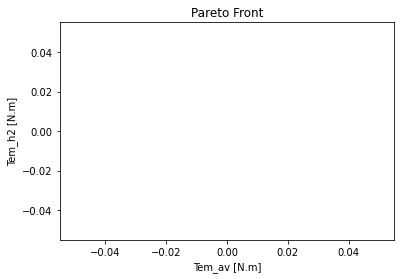

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt 

# Create a figure containing 4 subfigures (axes) 
fig = plt.figure()

# Plot pareto front in fitness space 
res.plot_pareto(
    x_symbol = "Tem_av", 
    y_symbol = "Tem_h2", 
    is_show_fig=True
)

fig.tight_layout()